In [2]:
import importlib

required_packages = [
    'scanpy',
    'igraph',
    'scipy',
    'leidenalg'
]

for package in required_packages:
    try:
        importlib.import_module(package)
        print(f"{package} is already installed.")
    except ImportError:
        print(f"{package} is not installed. Installing...")
        !pip install {package}

scanpy is already installed.
igraph is already installed.
scipy is already installed.
leidenalg is already installed.


In [3]:
# Necessary modules
import scanpy as sc
import numpy as np
import pandas as pd
from scipy.io import mmread
import matplotlib.pyplot as plt

In [4]:
# Barcode tsv file
RNA_barcodes = pd.read_csv("GSE126074_AdBrainCortex_SNAREseq_cDNA.barcodes.tsv", sep='\t', header=None)
RNA_barcodes

,0
0,09A_CAGCCCCGCCTT
1,09A_CGCCTACCATGA
2,09A_GATGCGCGGCTA
3,09A_GGTCCGAGTCCT
4,09A_TCTCCCGGCACC
...,...
10304,09L_TACTAGTTCAAG
10305,09L_ATGACGGGCCCC
10306,09L_GAAACACCTCAT
10307,09L_AACGGTTTATCC


In [5]:
# Gene tsv file

RNA_genes = pd.read_csv("GSE126074_AdBrainCortex_SNAREseq_cDNA.genes.tsv", sep='\t', header=None)
RNA_genes

,0
0,0610005C13Rik
1,0610007P14Rik
2,0610009B22Rik
3,0610009E02Rik
4,0610009L18Rik
...,...
33155,Vmn2r-ps83
33156,Vmn2r50
33157,Vpreb2
33158,n-R5s32


In [6]:
# Main data

RNA_counts = sc.read_mtx('GSE126074_AdBrainCortex_SNAREseq_cDNA.counts.mtx')
RNA_counts.var['barcodes'] = RNA_barcodes
RNA_counts.obs['genes'] = RNA_genes
RNA_counts.var.index = RNA_barcodes
RNA_counts.obs.index = RNA_genes
RNA_counts


AnnData object with n_obs × n_vars = 33160 × 10309
    obs: 'genes'
    var: 'barcodes'

In [7]:
RNA_counts = RNA_counts.T
RNA_counts

/opt/anaconda3/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/opt/anaconda3/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 10309 × 33160
    obs: 'barcodes'
    var: 'genes'

In [8]:
# Select highly variable genes

sc.pp.normalize_total(RNA_counts, target_sum=1e4)
sc.pp.log1p(RNA_counts)
sc.pp.highly_variable_genes(RNA_counts, min_mean=0.0125, max_mean=3, min_disp=0.5)
RNA_counts = RNA_counts[:, RNA_counts.var['highly_variable']]
sc.pp.scale(RNA_counts, max_value=10)

print(RNA_counts.shape)

(10309, 5641)


/opt/anaconda3/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [9]:
# To find the least dimension to make sure that 90% variance is preserved, we start from the max number of components.
sc.tl.pca(RNA_counts, svd_solver='arpack', n_comps=3500)

In [10]:
# Data after PCA

pca_data = RNA_counts.obsm['X_pca']
pca_data

array([[-0.03699459,  1.643129  ,  4.2730837 , ..., -0.76132745,
         0.4223365 ,  1.9212272 ],
       [ 0.6604982 ,  4.6104503 ,  8.171833  , ..., -0.41099364,
         0.48975685,  0.3405067 ],
       [13.268887  ,  2.6830673 ,  7.757345  , ..., -0.02633384,
        -0.37567294, -1.482996  ],
       ...,
       [-2.455755  , -3.3804235 , -4.082874  , ..., -0.49188226,
        -0.51368105, -0.17569885],
       [-2.1699283 ,  0.20570943,  0.49984813, ..., -0.08260532,
        -0.5225769 , -0.09070548],
       [-2.9470308 , -3.7031853 , -4.010265  , ..., -0.4628152 ,
        -0.6040274 , -0.01475736]], dtype=float32)

In [11]:
# Find the smallest dimension number

variance_ratios = RNA_counts.uns['pca']['variance_ratio']
cumulative_var = np.cumsum(variance_ratios)

p = np.argmax(cumulative_var >= 0.90) + 1

print(f'{p} principle components are selected to keep a variance of 90%.')

3257 principle components are selected to keep a variance of 90%.


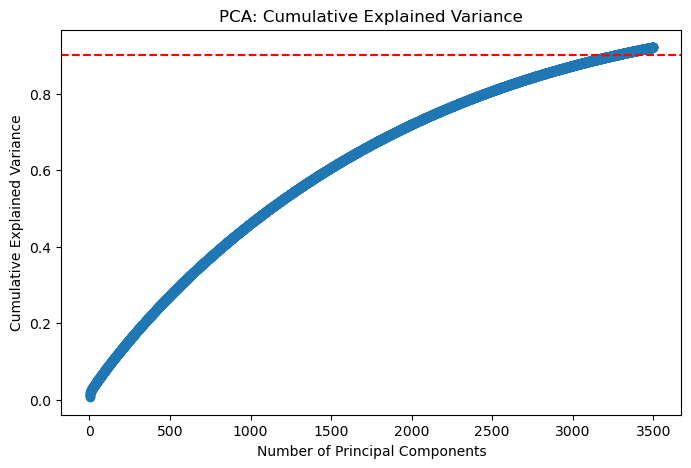

In [12]:
# Prove that 3257 PCs can make the variance 90%

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, marker='o', linestyle='--')
plt.axhline(y=0.90, color='r', linestyle='--')  # 90% variance line
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA: Cumulative Explained Variance")
plt.show()

In [13]:
# PCA with the number of components 3257
X = RNA_counts.X
sc.tl.pca(RNA_counts, svd_solver='arpack', n_comps=p, return_info=True)

In [14]:
# X_bar is data after PCA, X_hat is data from projection of X back to the original space.
X_bar = RNA_counts.obsm['X_pca']
components = RNA_counts.varm['PCs']


mean = np.mean(RNA_counts.X, axis=0)
X_hat = np.dot(X_bar, components.T) + mean

In [15]:
print(X_hat.shape)
print("\n")
print(X_hat)

(10309, 5641)


[[ 4.76710461e+00 -1.64563530e-01 -4.70342887e-01 ... -3.70731330e-02
  -3.52139451e-01 -2.45215347e-01]
 [-4.58475714e-01  4.55121193e+00 -3.87608392e-01 ... -5.19560665e-01
   2.55019669e-01 -1.43041523e-01]
 [-3.13818048e-01 -6.34351483e-04  2.27222346e+00 ... -1.29115279e-02
   2.65002950e-02 -1.10402577e-01]
 ...
 [-2.76173256e-01 -1.55894120e-01 -1.60392536e-01 ... -9.18252374e-02
  -4.15738358e-01 -8.08549553e-02]
 [-3.29531559e-01  3.50261082e-01 -3.77547911e-01 ...  1.09444590e-01
  -6.42275397e-02 -2.52885479e-01]
 [-1.44349285e-01  1.60880597e-01 -3.16232826e-01 ... -4.98966826e-03
  -1.04200373e-01  1.37316763e-01]]


<Axes: title={'center': 'X'}, xlabel='UMAP1', ylabel='UMAP2'>

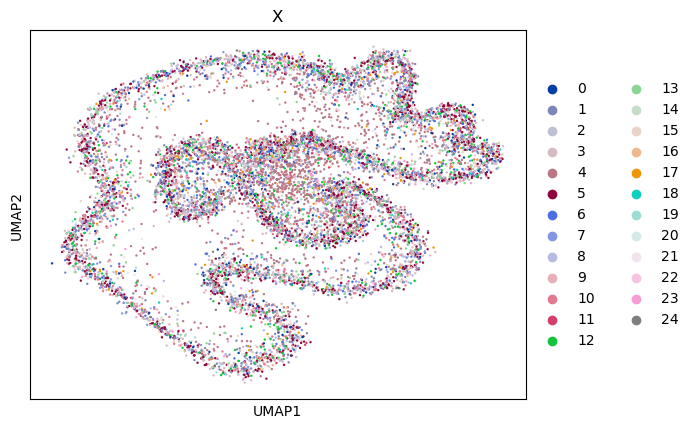

In [17]:
sc.pp.neighbors(RNA_counts, use_rep='X')
sc.tl.leiden(RNA_counts, flavor='igraph', n_iterations=2, resolution=1.4, key_added='leiden_1.4')
sc.tl.umap(RNA_counts)
sc.pl.umap(RNA_counts, color='leiden_1.4', title='X', show=False)
# Clusters by X

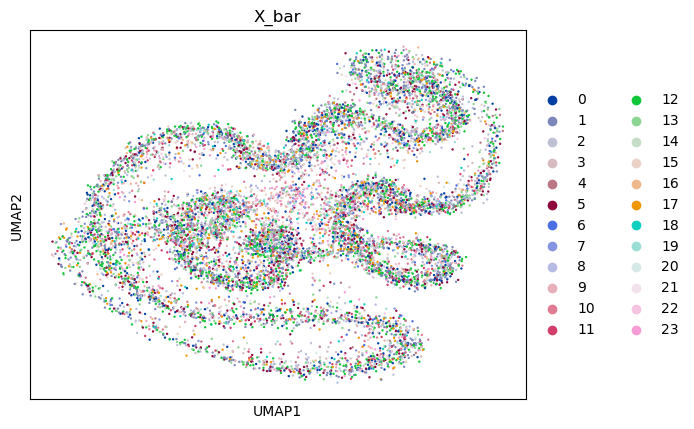

In [18]:
sc.pp.neighbors(RNA_counts, use_rep='X_pca')
sc.tl.leiden(RNA_counts, flavor='igraph', n_iterations=2, resolution=1.4, key_added='leiden_1.4')
sc.tl.umap(RNA_counts)
sc.pl.umap(RNA_counts, color='leiden_1.4', title='X_bar')
# Clusters by X_bar

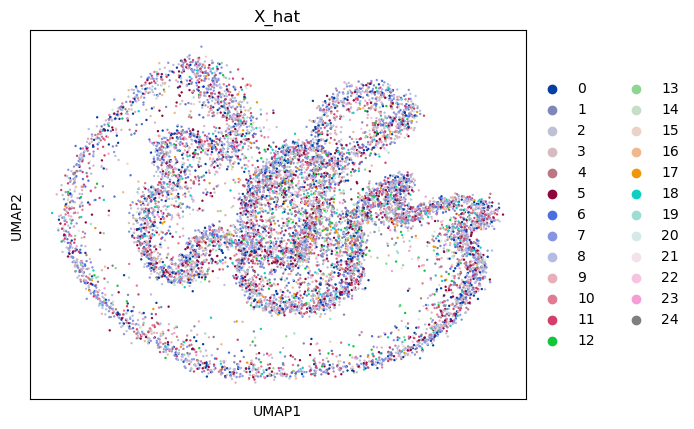

In [19]:
RNA_counts.obsm['X_hat'] = X_hat
sc.pp.neighbors(RNA_counts, use_rep='X_hat')
sc.tl.leiden(RNA_counts, flavor='igraph', n_iterations=2, resolution=1.4, key_added='leiden_1.4')
sc.tl.umap(RNA_counts)
sc.pl.umap(RNA_counts, color='leiden_1.4', title='X_hat')
# Clusters by X_hat

computing neighbors
    finished (0:00:07)
running Leiden clustering
    finished (0:00:00)
running PAGA
    finished (0:00:00)
computing UMAP
    finished (0:00:02)
ranking genes
    finished (0:00:03)


/opt/anaconda3/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/anaconda3/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/anaconda3/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/anaconda3/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/anaconda3/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/anaconda3/lib/python3.12/site-packages/scanpy/tools/_ra

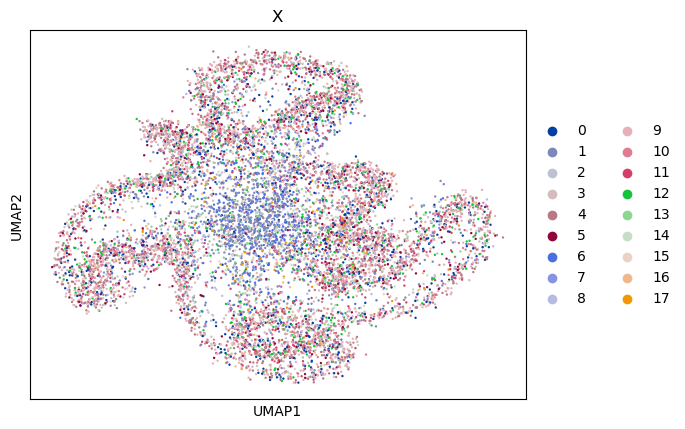

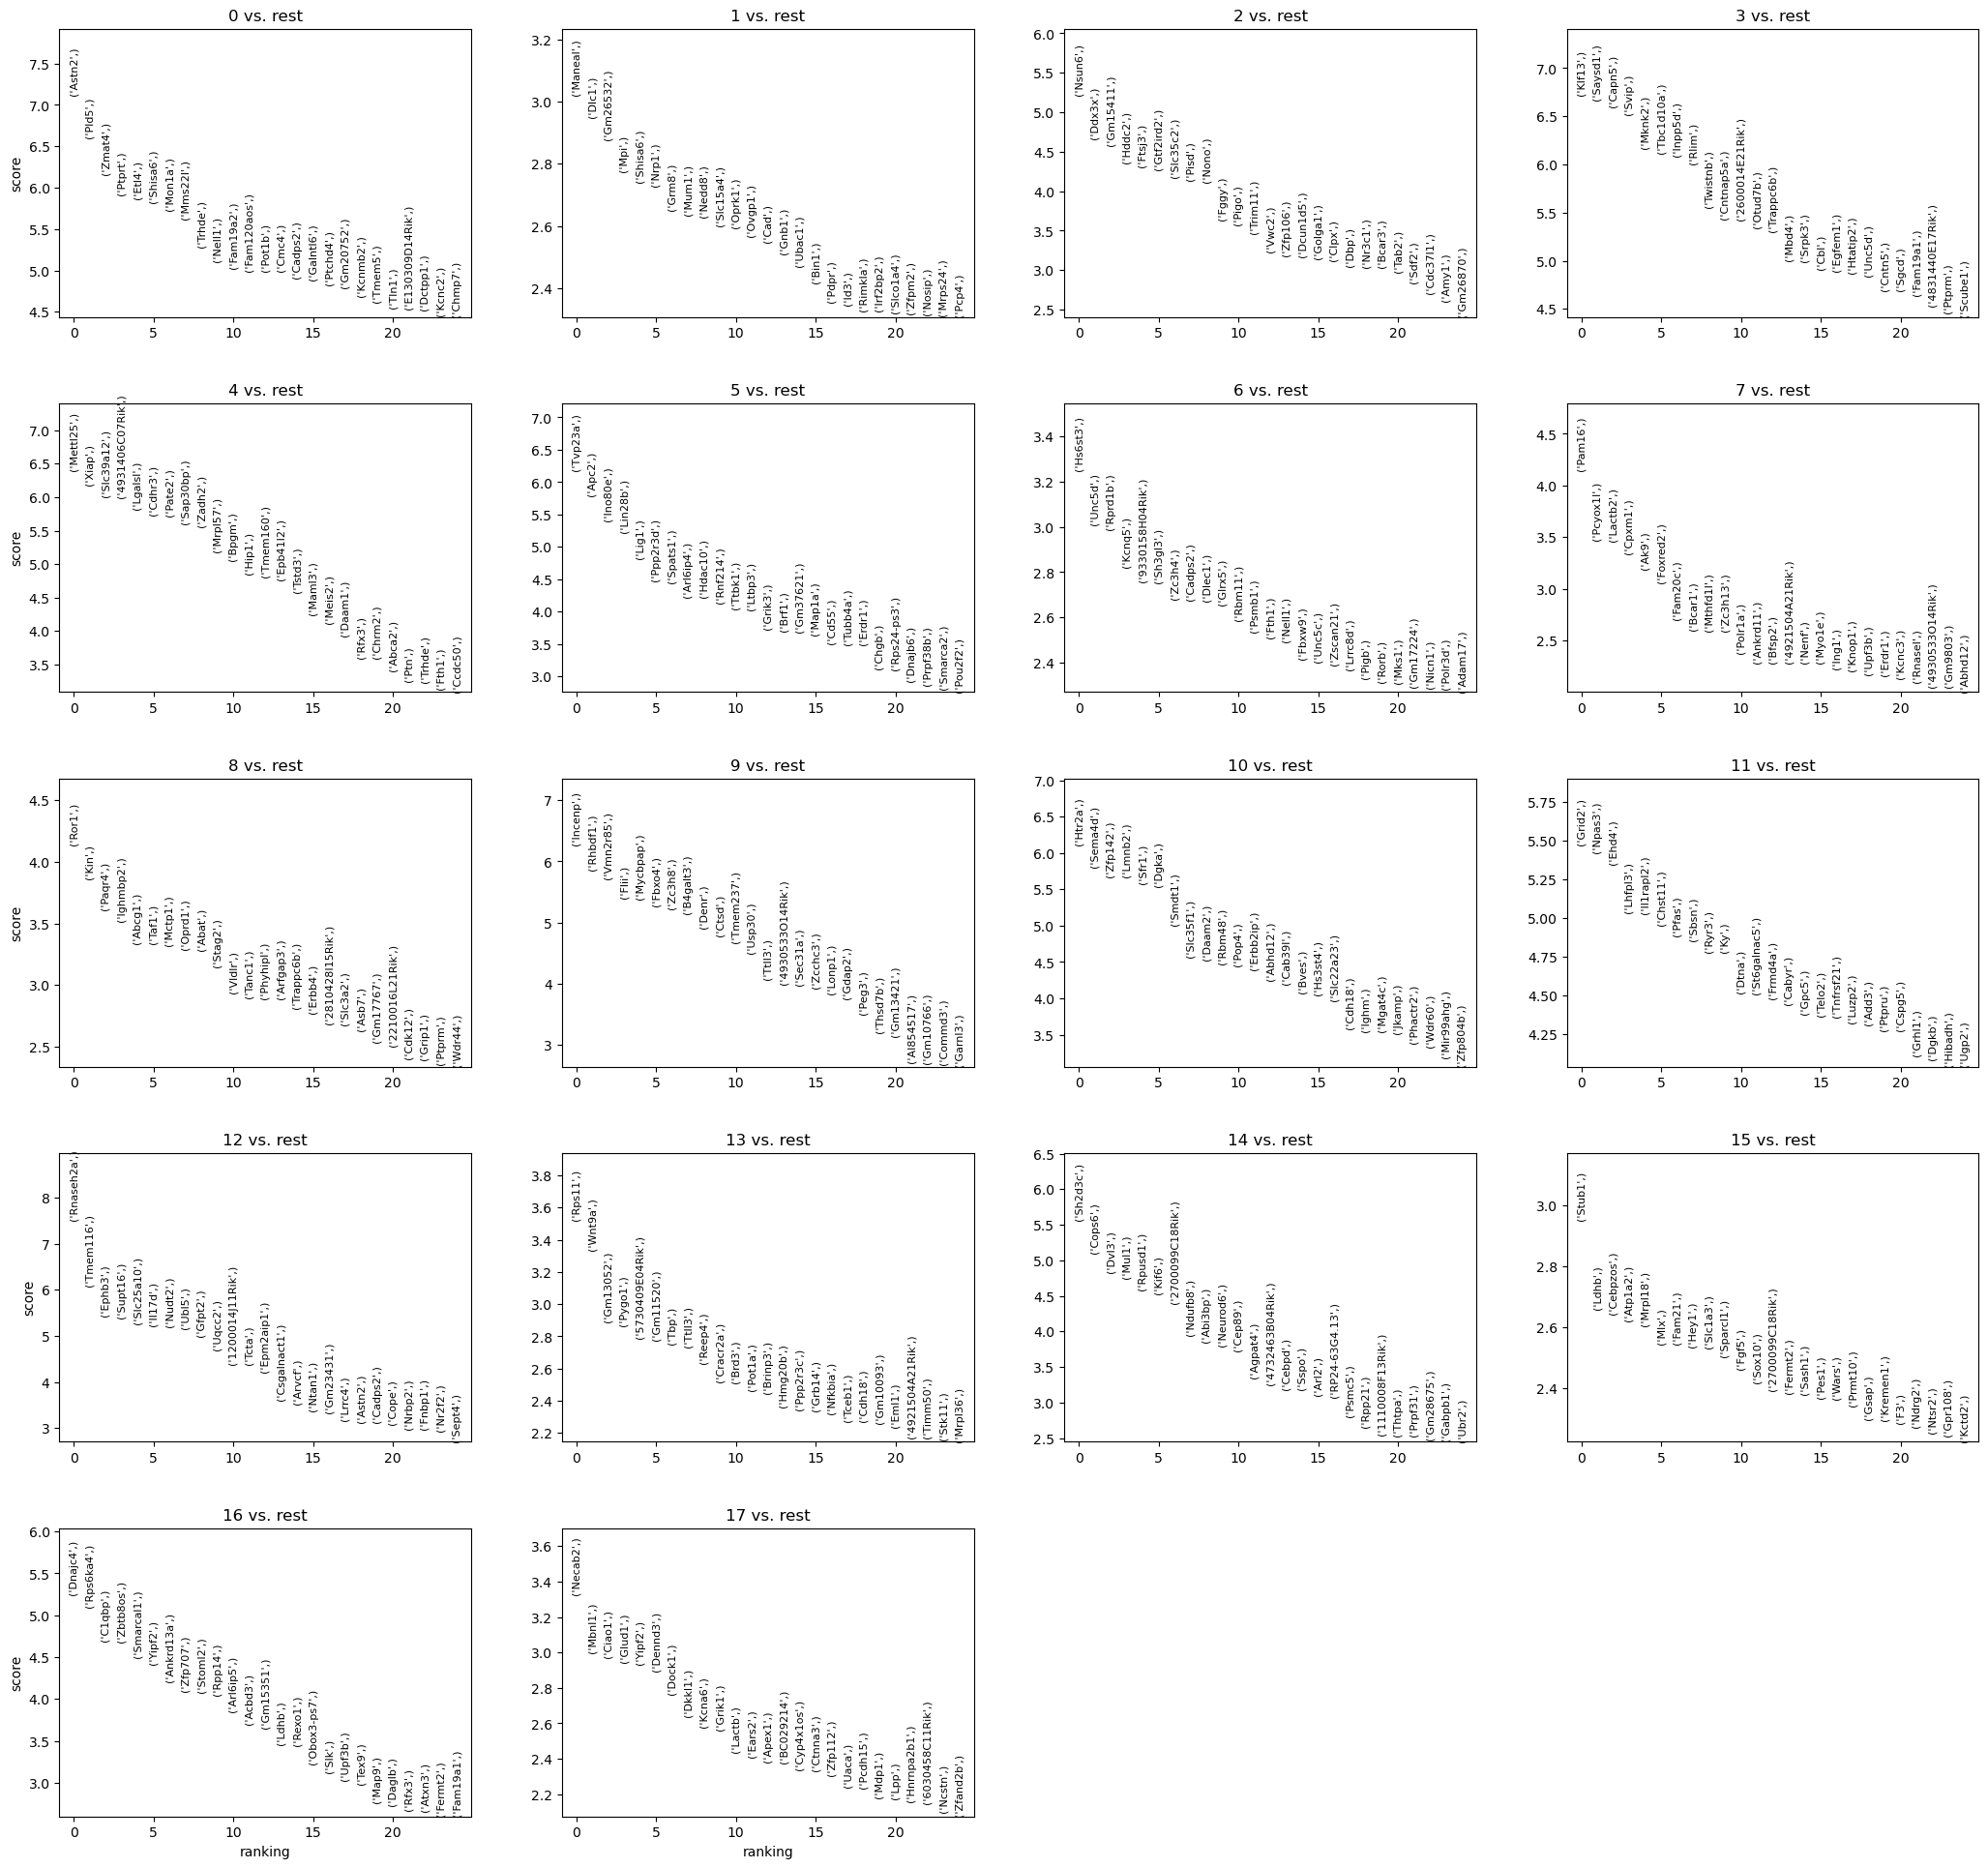

In [52]:
sc.pp.neighbors(RNA_counts, use_rep='X', n_neighbors=10, n_pcs=None)
sc.tl.leiden(
    RNA_counts,
    resolution=1.4,
    random_state=0,
    flavor="igraph",
    n_iterations=2,
    directed=False,
    key_added="leiden_1.4"
)
sc.tl.paga(RNA_counts, groups='leiden_1.4')
sc.pl.paga(RNA_counts, plot=False)
sc.tl.umap(RNA_counts, init_pos='paga')

sc.pl.umap(RNA_counts, color='leiden_1.4', title='X', show=False)
#sc.tl.leiden(RNA_counts)
#sc.tl.rank_genes_groups(RNA_counts, 'leiden', method='wilcoxon')
#sc.pl.highest_expr_genes(RNA_counts, n_top=25)
#sc.pl.rank_genes_groups(RNA_counts, n_genes=25, sharey=False)
sc.tl.rank_genes_groups(RNA_counts, "leiden_1.4", method="t-test")
sc.pl.rank_genes_groups(RNA_counts, n_genes=25, sharey=False)

In [53]:
# Gene ranking of the original dataset
ranked_genes = RNA_counts.uns['rank_genes_groups']

clusters = ranked_genes['names'].dtype.names  # 例如 ('0', '1', '2', ...)

gene_ranking_dict = {cluster: list(ranked_genes['names'][cluster][:20]) for cluster in clusters}

for i in range(18):
    print(f"Cluster {i}: {gene_ranking_dict[f'{i}']}")
    print('\n')

Cluster 0: ["('Astn2',)", "('Pld5',)", "('Zmat4',)", "('Ptprt',)", "('Etl4',)", "('Shisa6',)", "('Mon1a',)", "('Mms22l',)", "('Trhde',)", "('Nell1',)", "('Fam19a2',)", "('Fam120aos',)", "('Pot1b',)", "('Cmc4',)", "('Cadps2',)", "('Galntl6',)", "('Ptchd4',)", "('Gm20752',)", "('Kcnmb2',)", "('Tmem5',)"]


Cluster 1: ["('Maneal',)", "('Dlc1',)", "('Gm26532',)", "('Mpi',)", "('Shisa6',)", "('Nrp1',)", "('Grm8',)", "('Mum1',)", "('Nedd8',)", "('Slc15a4',)", "('Oprk1',)", "('Ovgp1',)", "('Cad',)", "('Gnb1',)", "('Ubac1',)", "('Bin1',)", "('Pdpr',)", "('Id3',)", "('Rimkla',)", "('Irf2bp2',)"]


Cluster 2: ["('Nsun6',)", "('Ddx3x',)", "('Gm15411',)", "('Hddc2',)", "('Ftsj3',)", "('Gtf2ird2',)", "('Slc35c2',)", "('Pisd',)", "('Nono',)", "('Fggy',)", "('Pigo',)", "('Trim11',)", "('Vwc2',)", "('Zfp106',)", "('Dcun1d5',)", "('Golga1',)", "('Clpx',)", "('Dbp',)", "('Nr3c1',)", "('Bcar3',)"]


Cluster 3: ["('Klf13',)", "('Saysd1',)", "('Capn5',)", "('Svip',)", "('Mknk2',)", "('Tbc1d10a',)", "('Inpp

computing neighbors
    finished (0:00:07)
running Leiden clustering
    finished (0:00:00)
running PAGA
    finished (0:00:00)
computing UMAP
    finished (0:00:02)
ranking genes
    finished (0:00:03)


/opt/anaconda3/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/anaconda3/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/anaconda3/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/anaconda3/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/anaconda3/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/anaconda3/lib/python3.12/site-packages/scanpy/tools/_ra

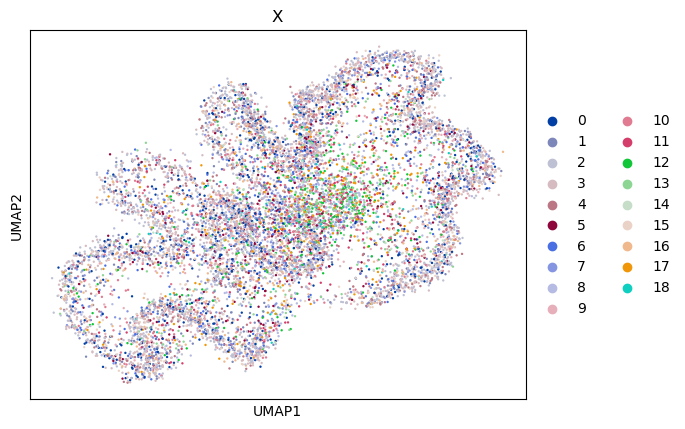

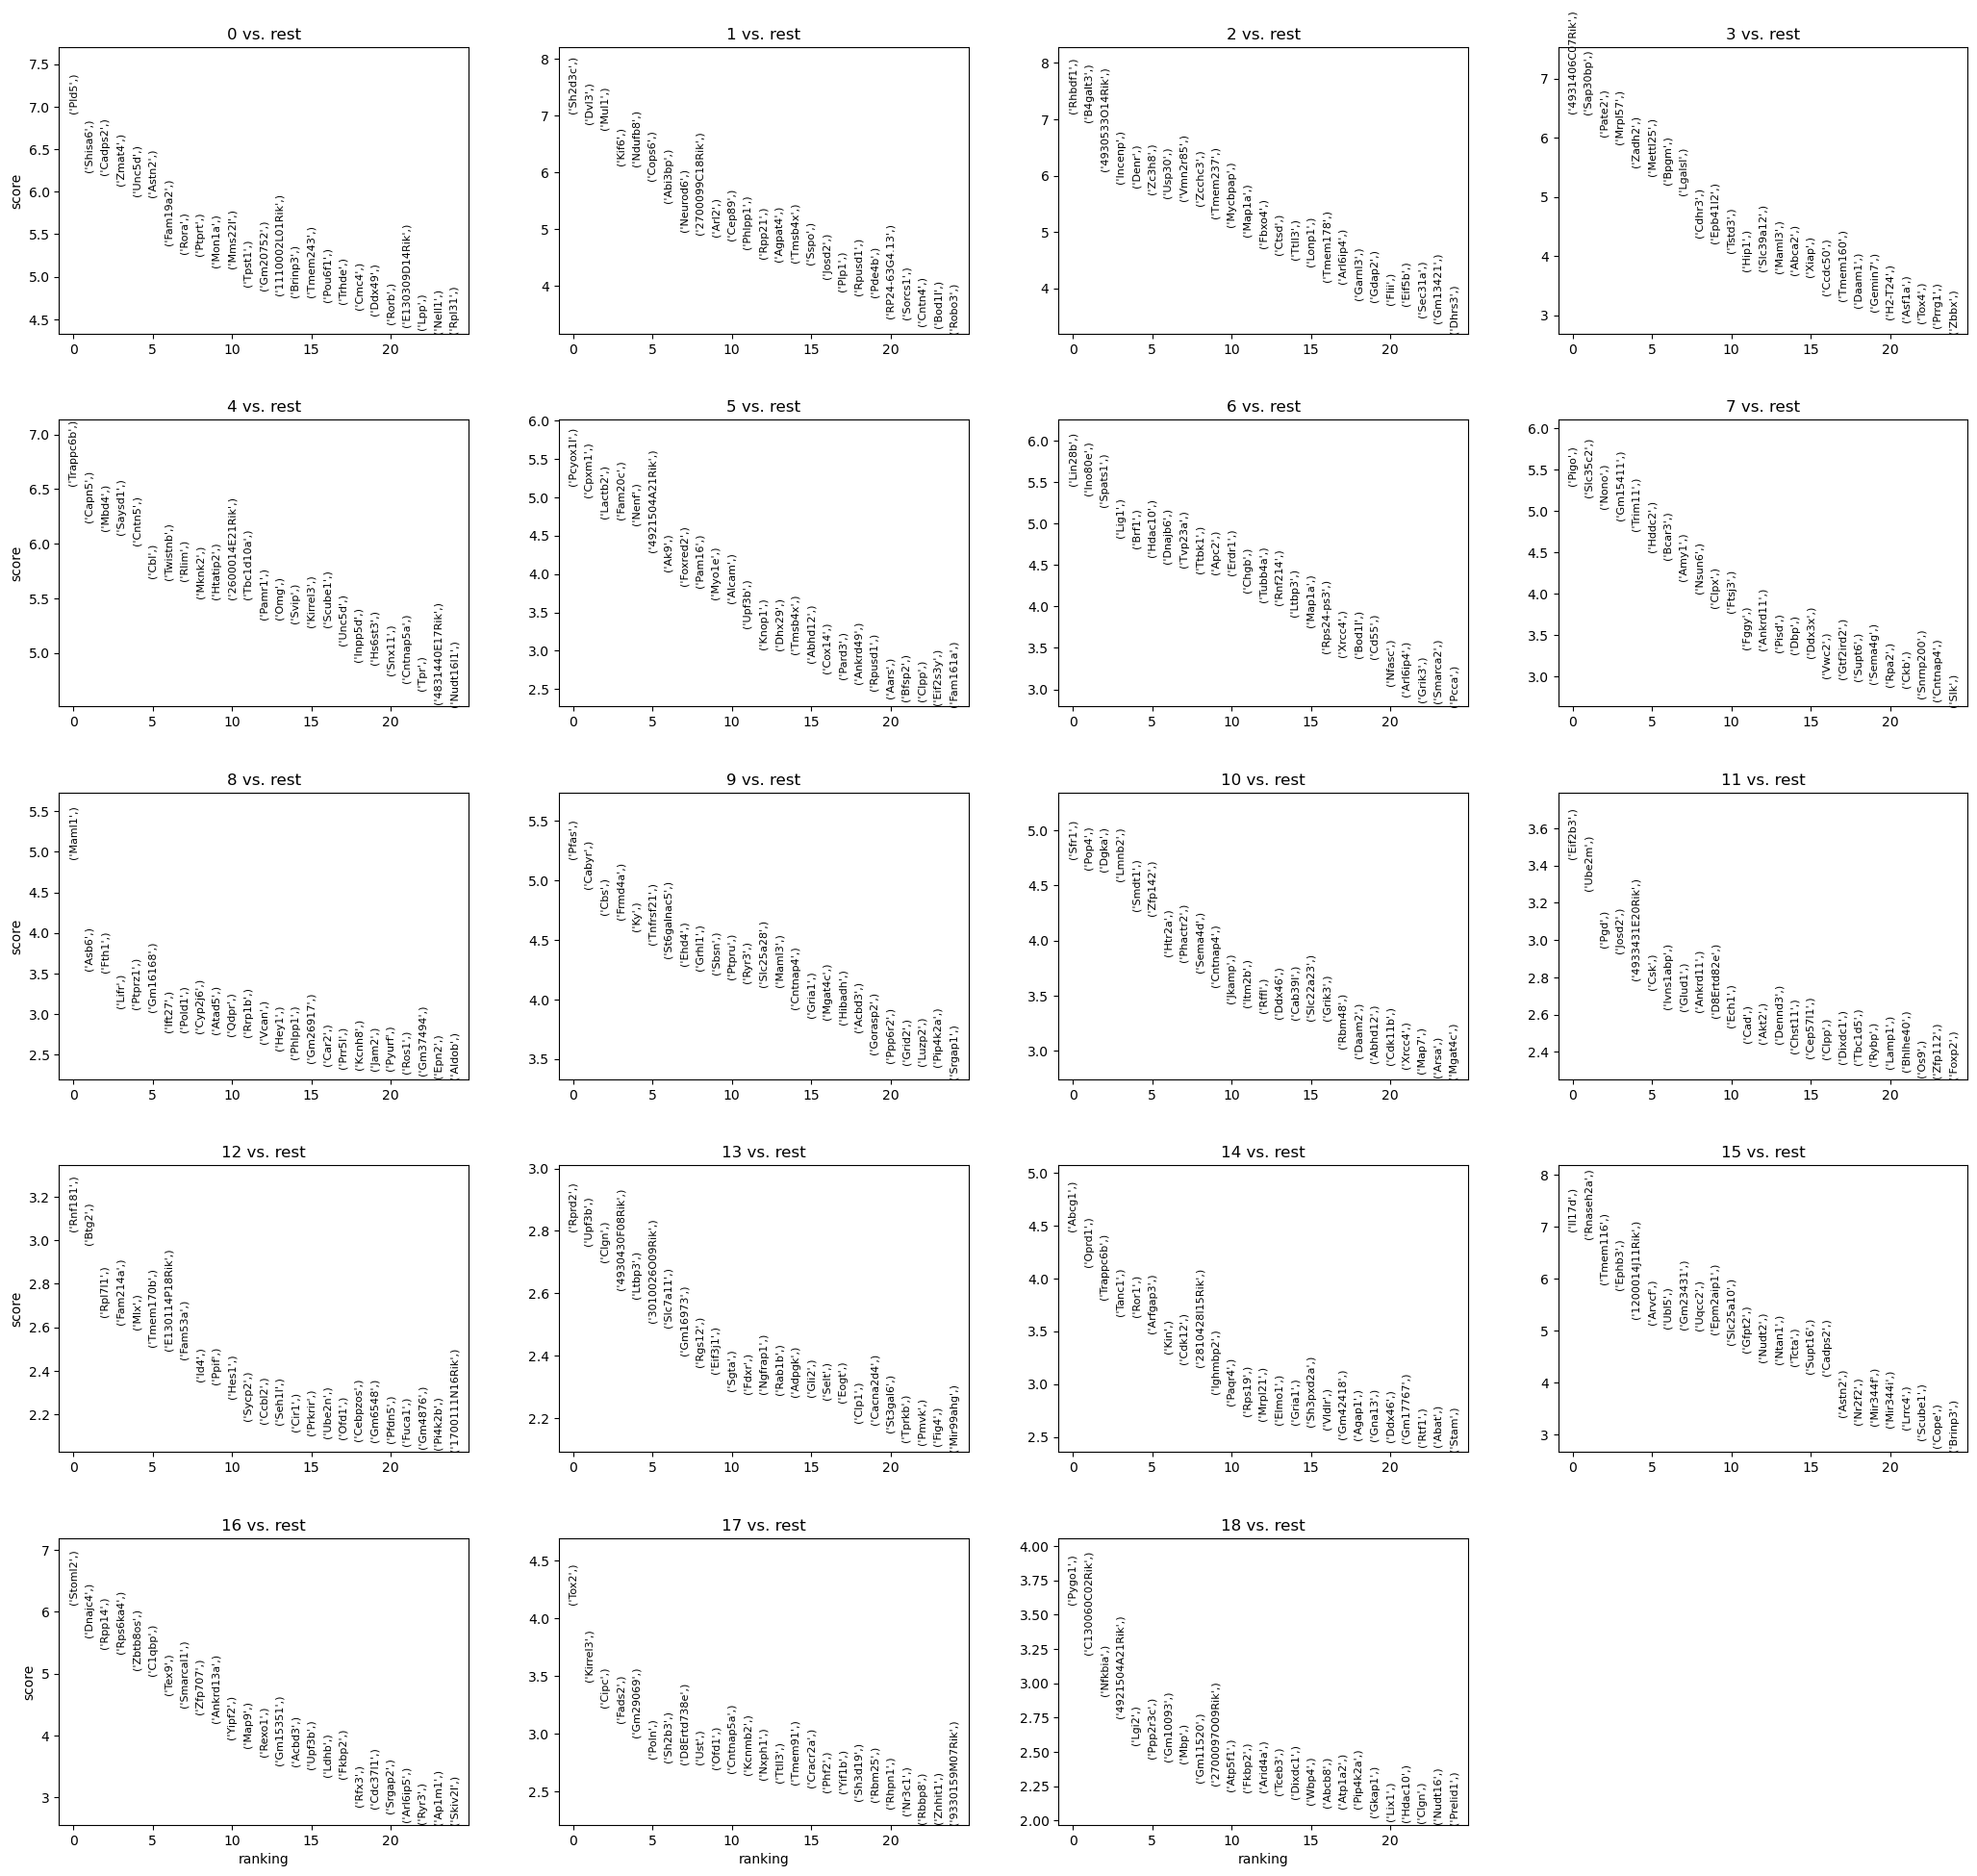

In [54]:
sc.pp.neighbors(RNA_counts, use_rep='X_hat', n_neighbors=10, n_pcs=None)
sc.tl.leiden(
    RNA_counts,
    resolution=1.4,
    random_state=0,
    flavor="igraph",
    n_iterations=2,
    directed=False,
    key_added="leiden_1.4"
)
sc.tl.paga(RNA_counts, groups='leiden_1.4')
sc.pl.paga(RNA_counts, plot=False)
sc.tl.umap(RNA_counts, init_pos='paga')

sc.pl.umap(RNA_counts, color='leiden_1.4', title='X', show=False)
#
#sc.tl.rank_genes_groups(RNA_counts, 'leiden', method='wilcoxon')
#sc.pl.highest_expr_genes(RNA_counts, n_top=25)
#sc.pl.rank_genes_groups(RNA_counts, n_genes=25, sharey=False)
sc.settings.verbosity = 2
sc.tl.rank_genes_groups(RNA_counts, "leiden_1.4", method="t-test")
sc.pl.rank_genes_groups(RNA_counts, n_genes=25, sharey=False)

In [55]:
# Gene ranking of the projected dataset
ranked_genes = RNA_counts.uns['rank_genes_groups']

clusters = ranked_genes['names'].dtype.names  # 例如 ('0', '1', '2', ...)

gene_ranking_dict = {cluster: list(ranked_genes['names'][cluster][:20]) for cluster in clusters}

for i in range(18):
    print(f"Cluster {i}: {gene_ranking_dict[f'{i}']}")
    print('\n')

Cluster 0: ["('Pld5',)", "('Shisa6',)", "('Cadps2',)", "('Zmat4',)", "('Unc5d',)", "('Astn2',)", "('Fam19a2',)", "('Rora',)", "('Ptprt',)", "('Mon1a',)", "('Mms22l',)", "('Tpst1',)", "('Gm20752',)", "('1110002L01Rik',)", "('Brinp3',)", "('Tmem243',)", "('Pou6f1',)", "('Trhde',)", "('Cmc4',)", "('Ddx49',)"]


Cluster 1: ["('Sh2d3c',)", "('Dvl3',)", "('Mul1',)", "('Kif6',)", "('Ndufb8',)", "('Cops6',)", "('Abi3bp',)", "('Neurod6',)", "('2700099C18Rik',)", "('Arl2',)", "('Cep89',)", "('Phlpp1',)", "('Rpp21',)", "('Agpat4',)", "('Tmsb4x',)", "('Sspo',)", "('Josd2',)", "('Plp1',)", "('Rpusd1',)", "('Pde4b',)"]


Cluster 2: ["('Rhbdf1',)", "('B4galt3',)", "('4930533O14Rik',)", "('Incenp',)", "('Denr',)", "('Zc3h8',)", "('Usp30',)", "('Vmn2r85',)", "('Zcchc3',)", "('Tmem237',)", "('Mycbpap',)", "('Map1a',)", "('Fbxo4',)", "('Ctsd',)", "('Ttll3',)", "('Lonp1',)", "('Tmem178',)", "('Arl6ip4',)", "('Garnl3',)", "('Gdap2',)"]


Cluster 3: ["('4931406C07Rik',)", "('Sap30bp',)", "('Pate2',)", "('Mr

Top genes of each cluster in original dataset: Astn2, Maneal, Nsun6, Klf13, Mettl25, Tvp23a, Hs6st3, Pam16, Ror1, Incenp, Htr2a, Grid2, Rnaseh2a, Rps11, Sh2d3c, Stub1, Dnajc4, Necab2
Top genes of each cluster in reporjected dataset: Pld5, Sh2d3c, Rhbdf1, 4931406C07Rik, Trappc6b, Pcyox1l, Lin28b, Pigo, Maml1, Pfas, Sfr1, Eif2b3, Rnf181, Rnaseh2a, Rprd2, Abcg1, Il17d, Stoml2, Tox2
Common genes: RNaseh2a, Sh2d3c.